In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import tensorflow as tf

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import math

## Parameters

In [5]:
NSAMPLE = 2500

In [6]:
from aml_dl.mdn.training.config import network_params_inv

AML_DATA environment variable is not set.
Training data folder does not exist...


In [7]:
from aml_dl.mdn.model.mdn_push_inv_model import MDNPushInverseModel

In [8]:
sess = tf.InteractiveSession()

In [13]:
inverse_model = MDNPushInverseModel(sess=sess, network_params=network_params_inv)
inverse_model.init_model()

In [49]:
x_curr   = np.random.randn(1,7).tolist()[0]
x_tgt    = np.random.randn(1,7).tolist()[0]
u_action = np.random.random((1,2))

In [50]:
input_x = np.expand_dims(np.r_[x_curr, x_tgt], 0)
mus = inverse_model.run_op('mu', input_x)[0]
sigma = inverse_model.run_op('sigma', input_x)[0]
pis = inverse_model.run_op('pi', input_x)[0]
loss = inverse_model._mdn.run_op(sess,'loss', xs = input_x, ys = u_action)[0]

print "MUS: ", mus
print "SIGMA: ", sigma
print "PIs:", pis
print "LOSS:", loss
#theta = inverse_model.sample_out_max_pi(input_x, 1)[0]
    
pi_idx = inverse_model._max_pi_idx(pis)

action = mus[:,pi_idx]


MUS:  [[ 4.26189995  0.76241481 -1.73527324 -3.53621173 -2.66223216]
 [ 0.94343185 -0.94690669 -2.75582409 -0.66426665  0.41089126]]
SIGMA:  [  8.21395040e-01   4.65166748e+02   4.60725874e-01   1.36959517e+00
   6.08531594e-01]
PIs: [ 0.41889668  0.08159102  0.03049874  0.20658152  0.26243204]
LOSS: [[ 31.28066635]]


In [9]:
network_params_inv['dim_input'] = 1
network_params_inv['dim_output'] = 1
network_params_inv['k_mixtures'] = 24

inverse_model = MDNPushInverseModel(sess=sess, network_params=network_params_inv)
inverse_model.init_model()

In [10]:
xs = np.random.uniform(-10.5, 10.5, (6, NSAMPLE)).T
ys = np.random.uniform(-10.5, 10.5, (3, NSAMPLE)).T

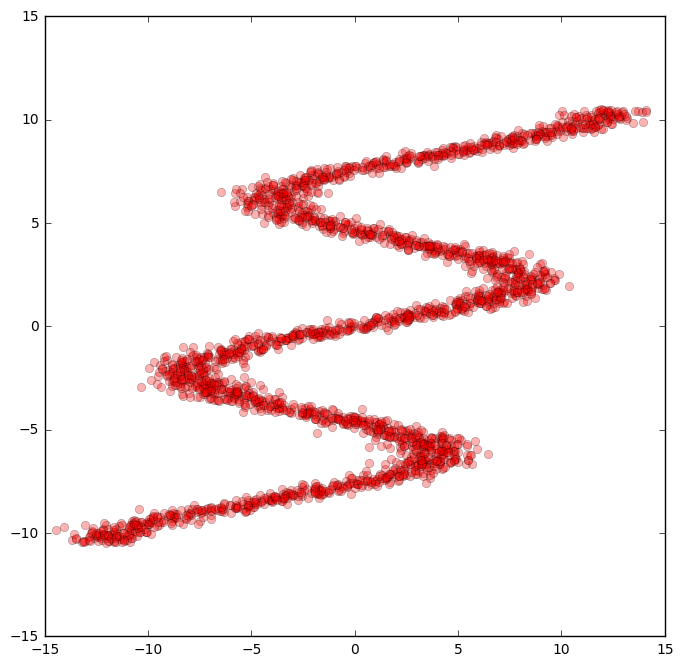

In [11]:
y_data = np.float32(np.random.uniform(-10.5, 10.5, (1, NSAMPLE))).T
r_data = np.float32(np.random.normal(size=(NSAMPLE,1))) # random noise
x_data = np.float32(np.sin(0.75*y_data)*7.0+y_data*0.5+r_data*1.0)

plt.figure(figsize=(8, 8))
plt.plot(x_data,y_data,'ro', alpha=0.3)
plt.show()

In [12]:
sess.run(tf.global_variables_initializer())

NEPOCH = 10000
loss = np.zeros(NEPOCH) # store the training progress here.
for i in range(NEPOCH):
  sess.run(inverse_model._net_ops['train'],feed_dict={inverse_model._net_ops['x']: x_data, inverse_model._net_ops['y']: y_data})
  loss[i] = sess.run(inverse_model._net_ops['loss'], feed_dict={inverse_model._net_ops['x']: x_data, inverse_model._net_ops['y']: y_data})

In [13]:
print loss

[ 14.6238184   14.5324955   14.44163132 ...,   1.25241268   1.25241792
   1.25239921]


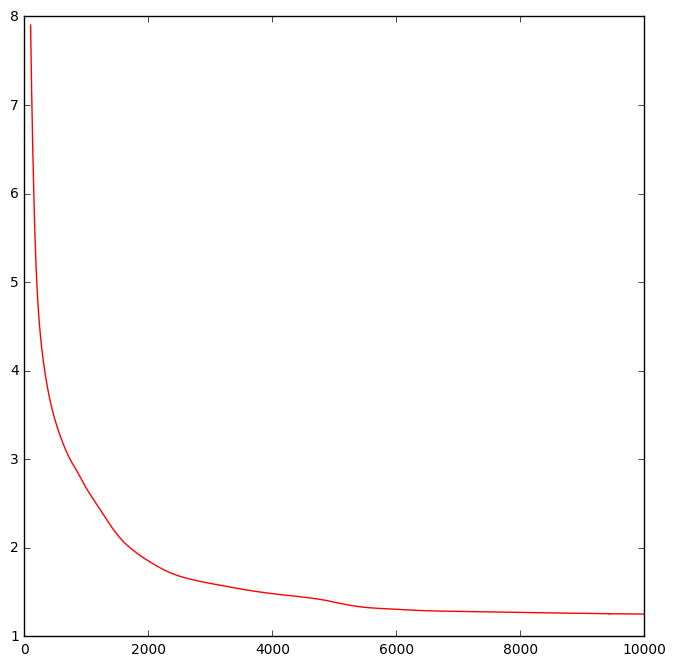

In [14]:
plt.figure(figsize=(8, 8))
plt.plot(np.arange(100, NEPOCH,1), loss[100:], 'r-')
plt.show()

In [15]:
from aml_dl.mdn.model.tf_mdn_model import MixtureOfGaussians

In [16]:
out_pi = inverse_model._net_ops['pi']
out_sigma = inverse_model._net_ops['sigma']
out_mu = inverse_model._net_ops['mu']
x = inverse_model._net_ops['x']

In [17]:
mixture = MixtureOfGaussians()

In [18]:
x_test = np.float32(np.arange(-15,15,0.1))
NTEST = x_test.size
x_test = x_test.reshape(NTEST,1) # needs to be a matrix, not a vector


In [19]:
out_pi_test, out_sigma_test, out_mu_test = sess.run([out_pi, out_sigma, out_mu], feed_dict={x: x_test})

In [20]:
# print out_mu_test.reshape((300,2))

In [22]:
out_mu_test = out_mu_test.reshape((300,24))
print out_pi_test.shape, x_test.shape, out_sigma_test.shape, out_mu_test.shape


(300, 24) (300, 1) (300, 24) (300, 24)


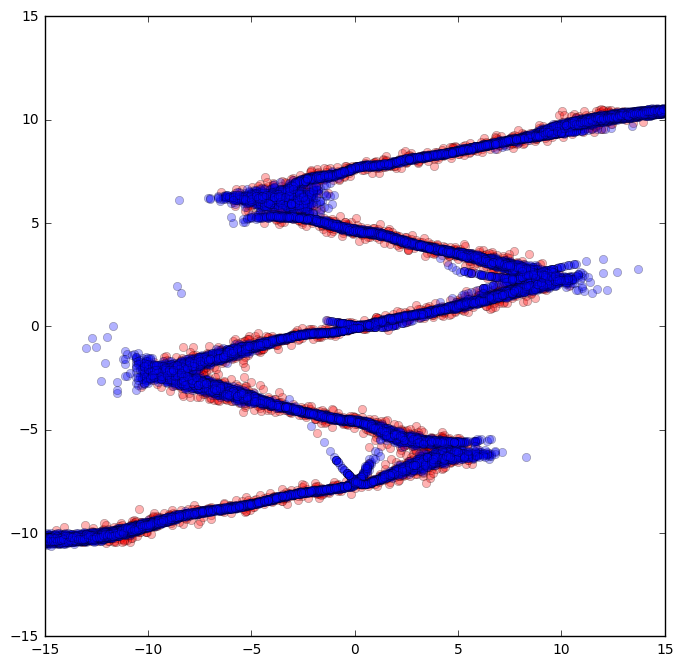

In [23]:


y_test = mixture.generate_mixture_samples(out_pi_test, out_mu_test, out_sigma_test,100)

plt.figure(figsize=(8, 8))
plt.plot(x_data,y_data,'ro', x_test,y_test,'bo',alpha=0.3)
plt.show()